# Chinook Database Schema
<img src="chinook_schema.svg" style="width:750px;height:750px"/>

## Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db ='chinook.db'

def run_query(query):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(query, conn)

def run_command(query):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    
    schema_query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    
    with sqlite3.connect(db) as conn:
        
        return run_query(schema_query)
    
schema = show_tables()
schema

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [2]:
sample_query = '''
SELECT *
FROM media_type
'''
run_query(sample_query)

,media_type_id,name
0,1,MPEG audio file
1,2,Protected AAC audio file
2,3,Protected MPEG-4 video file
3,4,Purchased AAC audio file
4,5,AAC audio file


## Protected Media

In [3]:
protected_media = '''
SELECT
    media_type_id,
    name,
    CASE
        WHEN name LIKE '%Protected%' THEN 1
        ELSE 0
        END
        AS protected
FROM media_type;
'''
run_query(protected_media)

,media_type_id,name,protected
0,1,MPEG audio file,0
1,2,Protected AAC audio file,1
2,3,Protected MPEG-4 video file,1
3,4,Purchased AAC audio file,0
4,5,AAC audio file,0


## Gathering information about employees and their respective supervisor.

In [4]:
employees = '''
select 
    (e1.first_name || ' ' || e1.last_name) employee_name, 
    e1.title employee_title,
    (e2.first_name || ' ' || e2.last_name) supervisor_name,
    e2.title supervisor_title
from employee e1
left join employee e2 on e2.employee_id = e1.reports_to
ORDER by 1
'''
run_query(employees)

,employee_name,employee_title,supervisor_name,supervisor_title
0,Andrew Adams,General Manager,None,None
1,Jane Peacock,Sales Support Agent,Nancy Edwards,Sales Manager
2,Laura Callahan,IT Staff,Michael Mitchell,IT Manager
3,Margaret Park,Sales Support Agent,Nancy Edwards,Sales Manager
4,Michael Mitchell,IT Manager,Andrew Adams,General Manager
5,Nancy Edwards,Sales Manager,Andrew Adams,General Manager
6,Robert King,IT Staff,Michael Mitchell,IT Manager
7,Steve Johnson,Sales Support Agent,Nancy Edwards,Sales Manager


## Analyzing Sales Support Agent's performance.

In [5]:
employee_performance_query = '''
SELECT 
    e.first_name || ' ' || e.last_name employee,
    e.hire_date,
    sum(i.total) total_sales_usd
FROM customer c
INNER JOIN invoice i on c.customer_id = i.customer_id
INNER JOIN employee e on c.support_rep_id = e.employee_id
GROUP BY employee
ORDER BY total_sales_usd DESC;
'''
run_query(employee_performance_query)

,employee,hire_date,total_sales_usd
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


## Customer Type
Let's categorize each customer assigning them the following values based on the total amount of money they've spent:

- small spender - If the customer's total purchases are less than USD 40
- regular - If the customer's total purchases are between USD 40 and USD 100 
- big spender - If the customer's total purchases are greater than USD 100

In [6]:
customer_type = '''
select 
    sq.customer_name,
    count(*) number_of_purchases,
    sum(i.Total) total_spent,
    case 
        when sum(i.Total) < 40 then 'small spender'
        when sum(i.Total) <= 100 then 'regular'
        else 'big spender'
        end as customer_category
from invoice i 
left join (select 
    (first_name || ' ' || last_name) customer_name,
    customer_id customer_id
    from customer) sq on sq.customer_id = i.customer_id
group by sq.customer_id
order by sq.customer_name
limit 20
'''
run_query(customer_type)

,customer_name,number_of_purchases,total_spent,customer_category
0,Aaron Mitchell,8,70.29,regular
1,Alexandre Rocha,10,69.30,regular
2,Astrid Gruber,9,69.30,regular
3,Bjørn Hansen,9,72.27,regular
4,Camille Bernard,9,79.20,regular
5,Daan Peeters,7,60.39,regular
6,Dan Miller,12,95.04,regular
7,Diego Gutiérrez,5,39.60,small spender
8,Dominique Lefebvre,9,72.27,regular
9,Eduardo Martins,12,60.39,regular


## Top 5 Albums
Let's find out the top 5 albums, as calculated by the number of times a track from that album has been purchased.

In [7]:
top_5 = '''
SELECT
    ta.album album,
    ta.artist_name artist,
    COUNT(*) tracks_purchased
FROM invoice_line il
INNER JOIN (
            SELECT
                t.track_id,
                ar.name artist_name,
                al.title album
            FROM track t
            INNER JOIN album al ON al.album_id = t.album_id
            INNER JOIN artist ar ON ar.artist_id = al.artist_id
           ) ta
           ON ta.track_id = il.track_id
GROUP BY 1
ORDER BY 3 DESC LIMIT 5;
'''
run_query(top_5)

,album,artist,tracks_purchased
0,Are You Experienced?,Jimi Hendrix,187
1,Faceless,Godsmack,96
2,Mezmerize,System Of A Down,93
3,Get Born,JET,90
4,The Doors,The Doors,83


## Selecting New Albums to Purchase
Consider the following scenario:

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

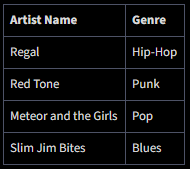

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

Let's find out which genres sell the most tracks in the USA, and then visualize the data.

In [9]:
sold_tracks_per_genre_usa = '''
WITH usa_sold_tracks as(
SELECT il.*
FROM invoice_line il
INNER JOIN invoice i on il.invoice_id = i.invoice_id
INNER JOIN customer c on i.customer_id = c.customer_id
WHERE c.country = 'USA'
)

SELECT 
    g.name genre,
    count(1) tracks_sold,
    round(cast(count(1) AS FLOAT) / (
        SELECT COUNT(1)
        FROM usa_sold_tracks
        ), 3) percentage_sold
FROM genre g
INNER JOIN track t on g.genre_id = t.genre_id
INNER JOIN usa_sold_tracks ust on t.track_id = ust.track_id
GROUP BY g.genre_id
ORDER BY tracks_sold DESC;
'''
run_query(sold_tracks_per_genre_usa)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.534
1,Alternative & Punk,130,0.124
2,Metal,124,0.118
3,R&B/Soul,53,0.050
4,Blues,36,0.034
5,Alternative,35,0.033
6,Pop,22,0.021
7,Latin,22,0.021
8,Hip Hop/Rap,20,0.019
9,Jazz,14,0.013


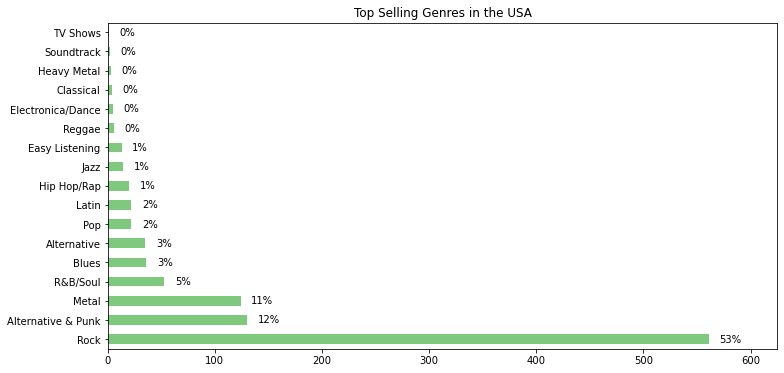

In [10]:
genre_sales_usa = run_query(sold_tracks_per_genre_usa)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

fig, ax = plt.subplots(figsize=(12,6))
genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the sales of tracks across different genres in the USA and the given options*, we should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

While there is a quite a difference in sales between Jane (the top employee) and Steve (the bottom employee), it may be explained by their hiring dates since Jane was hired 6 months earlier.

## Let's find the customer from each country who has spent the most on the store

In [11]:
best_customer_per_country = '''
with customer_country_purchases as 
    (select 
        c.country,
        c.first_name || ' ' || c.last_name customer_name,
        sum(i.total) total_purchased
    from invoice i
    left join customer c on c.customer_id = i.customer_id
    group by customer_name
    order by country, total_purchased)

select 
    country,
    customer_name, 
    max(total_purchased) total_purchased
from customer_country_purchases
group by country
order by total_purchased DESC
'''
run_query(best_customer_per_country)

,country,customer_name,total_purchased
0,Czech Republic,František Wichterlová,144.54
1,Ireland,Hugh O'Reilly,114.84
2,India,Manoj Pareek,111.87
3,Brazil,Luís Gonçalves,108.90
4,Portugal,João Fernandes,102.96
5,France,Wyatt Girard,99.99
6,Canada,François Tremblay,99.99
7,United Kingdom,Phil Hughes,98.01
8,USA,Jack Smith,98.01
9,Spain,Enrique Muñoz,98.01


## Analyzing Sales by Country

In [12]:
country_purchases='''

WITH country_or_other AS (
    SELECT
           CASE
               WHEN (
                     SELECT count(*)
                     FROM customer
                     where country = c.country
                    ) = 1 THEN "Other"
               ELSE c.country
           END AS country,
           c.customer_id,
           il.*
         FROM invoice_line il
         INNER JOIN invoice i ON i.invoice_id = il.invoice_id
         INNER JOIN customer c ON c.customer_id = i.customer_id
),

    sorting_query AS ( 
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / COUNT(distinct invoice_id) average_order,
        CASE
            WHEN lower(country) = 'other' THEN 1
            ELSE 0
        END sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, customers DESC
    )

SELECT
    country,
    customers,
    round(total_sales, 2) total_sales,
    round(average_order, 2) average_order,
    round(customer_lifetime_value, 2) customer_lifetime_value
FROM sorting_query
'''
run_query(country_purchases)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.94,80.04
1,Canada,8,535.59,7.05,66.95
2,Brazil,5,427.68,7.01,85.54
3,France,5,389.07,7.78,77.81
4,Germany,4,334.62,8.16,83.66
5,United Kingdom,3,245.52,8.77,81.84
6,Czech Republic,2,273.24,9.11,136.62
7,India,2,183.15,8.72,91.58
8,Portugal,2,185.13,6.38,92.57
9,Other,15,1094.94,7.45,73.00


## Visualizing Sales by Country

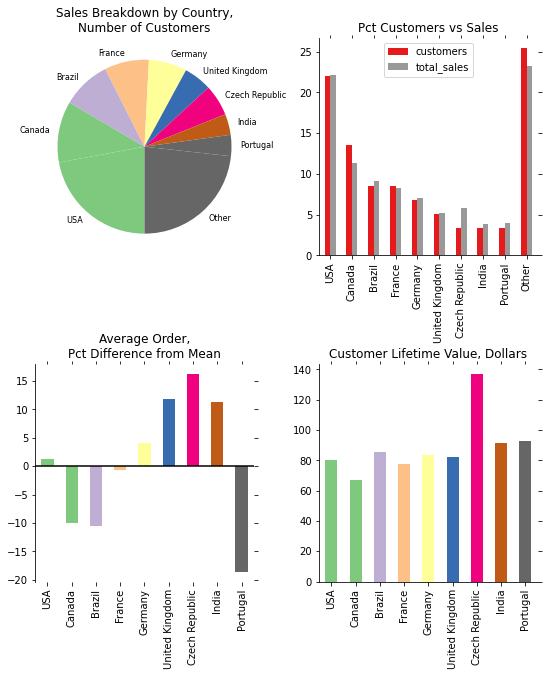

In [13]:

country_metrics = run_query(country_purchases)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India
- Portugal

It's worth keeping in mind that the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Albums vs Individual Tracks

In [14]:
album_vs_track = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    ),
    
    
    album_or_track AS
    (
    SELECT
            ifs.*,
            CASE
                WHEN
                     (
                      SELECT t.track_id FROM track t
                      WHERE t.album_id = (
                                          SELECT t2.album_id FROM track t2
                                          WHERE t2.track_id = ifs.first_track_id
                                         ) 

                      EXCEPT 

                      SELECT il2.track_id FROM invoice_line il2
                      WHERE il2.invoice_id = ifs.invoice_id
                     ) IS NULL
                 AND
                     (
                      SELECT il2.track_id FROM invoice_line il2
                      WHERE il2.invoice_id = ifs.invoice_id

                      EXCEPT 

                      SELECT t.track_id FROM track t
                      WHERE t.album_id = (
                                          SELECT t2.album_id FROM track t2
                                          WHERE t2.track_id = ifs.first_track_id
                                         ) 
                     ) IS NULL
                 THEN "yes"

                 ELSE "no"
             END AS "album_purchase"
         FROM invoice_first_track ifs
         )
         
SELECT
    album_purchase,
    COUNT(1) number_of_invoices,
    ROUND(CAST(COUNT(1) AS FLOAT) / (
                                SELECT COUNT(1)
                                FROM album_or_track
                                ), 3) * 100 percent
FROM album_or_track
GROUP BY album_purchase
    
'''
run_query(album_vs_track)

,album_purchase,number_of_invoices,percent
0,no,500,81.4
1,yes,114,18.6


Album purchases account for 18.6% of purchases. Based on this data, it might not be a good idea to allow clients to purchase only select tracks from albums from record companies, since there is potential to lose almost one fifth of revenue.